**Quanvolutional Neural Networks**

---


Quanvolutional Neural Networks (QNNs) are a quantum machine learning model inspired by classical convolutional neural networks (CNNs), which are effective for image processing tasks. The key idea is to apply quantum operations to local regions of an input image, similar to how CNNs use convolutional layers to process small patches of an image with shared weights, allowing the model to learn spatial hierarchies and features.


**Steps in Implementing Quanvolutional Neural Networks:**


1. **Input Embedding**:
  
**Description**: A small region of the input image, usually a $2 \times 2$ square, is embedded into a quantum circuit. This is achieved through parameterized rotations applied to qubits that are initially in the ground state.
  
**Purpose**: This step prepares the quantum system to process the image data by encoding the local image region into the quantum state, setting the stage for quantum computation.


2. **Quantum Computation**:
**Description**: A unitary operation \(U\) is performed on the quantum state. This unitary operation can be generated by either a variational quantum circuit or a random circuit.

**Purpose**: This transformation modifies the state of the qubits based on the input image region, enabling the quantum system to perform computations that could capture complex patterns and features from the image data.


3. **Measurement**:
  
**Description**: The quantum system is measured to obtain classical expectation values from the quantum state.

**Purpose**: Measurement provides the output of the quantum computation, converting quantum information into classical data that can be used for further processing or analysis.

4. **Output Mapping**:

**Description**: Each expectation value obtained from the measurement is mapped to a different channel of a single output pixel, similar to how CNNs produce feature maps.

**Purpose**: This step allows the model to generate multi-channel output images, enabling it to create complex representations of the input data that capture various features learned by the quantum convolution.

5. **Iterative Processing**:

**Description**: The process of embedding, computing, measuring, and mapping is repeated over different regions of the input image.

**Purpose**: By scanning the entire image, the QNN effectively learns from various parts of the image, allowing it to capture spatial features and patterns across the whole dataset.


6. **Integration with Classical Layers**:
**Description**: After quantum convolution,  classical layers will follow.

**Purpose**: This hybrid approach leverages the strengths of both quantum and classical computing, potentially improving the performance of the model by combining the unique capabilities of quantum computation with established classical techniques.


In [ ]:
#Install PennyLane in this Notebook
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.7 MB/s eta 0:00:00


The step below import essential libraries and modules required for implementing a quantum machine learning model using PennyLane and TensorFlow.

In [ ]:
%matplotlib inline
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

By importing these libraries, we set up the environment to facilitate the creation of quantum circuits, perform numerical computations, and visualize results, thereby laying the groundwork for building and training the Quanvolutional Neural Network.

Loading of the MNIST Dataset
============================

The MNIST dataset is loaded and the total number of samples is determined. The dataset is then split into training and testing sets using a 70-30% ratio, and indices are shuffled to ensure randomness. Finally, the dataset is reduced to the specified sizes for training and testing based on the shuffled indices.


In [26]:
# Load MNIST dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Combine the dataset
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Define the number of images to use
n_total_images = 200
n_train = int(0.7 * n_total_images)  # 70% for training
n_test = n_total_images - n_train    # Remaining for testing

# Shuffle and select the subset of data
indices = np.arange(len(all_images))
np.random.shuffle(indices)
subset_indices = indices[:n_total_images]

subset_images = all_images[subset_indices]
subset_labels = all_labels[subset_indices]

# Further split the subset into training and testing sets
train_indices = np.arange(n_train)
test_indices = np.arange(n_train, n_total_images)

train_images = subset_images[train_indices]
train_labels = subset_labels[train_indices]
test_images = subset_images[test_indices]
test_labels = subset_labels[test_indices]

# Print the number of images in the subsets
print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Total number of images in the dataset: {len(train_images) + len(test_images)}")

Number of training images: 140
Number of testing images: 60
Total number of images in the dataset: 200


**Data Pre-Processing**

Normalizes pixel values of the images to a range between 0 and 1 by dividing by 255. Thereafter, an extra dimension to the images to represent the convolutional channels, converting them into a format suitable for convolutional neural networks. This extra dimension is added using `tf.newaxis` and the images are converted to NumPy arrays with gradient tracking disabled.

In [27]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Setting of the Main Hyper-Parameters of the Model
=================================================


In [28]:
import os

# Create a new folder in Google Colab
SAVE_PATH = "/content/quanvolution/"  # New path for saving data
os.makedirs(SAVE_PATH, exist_ok=True)

# Define ranges for epochs and layers
epochs_range = range(10, 51, 10)  # Number of optimization epochs ranges from 10 to 50 with an interval of 10
layers_range = range(1, 6)        # Number of random layers ranges from 1 to 5 layers
PREPROCESS = True           # For quantum processing

Quantum Circuit as a Convolution Kernel
=======================================

In this setup, a quantum circuit is used as a convolution kernel. We initialize a `default.qubit` device with 4 qubits and define a quantum node (`qnode`) that comprises three parts: an embedding layer with local $( R_y )$ rotations, a random circuit with `n_layers`, and a final measurement to estimate 4 expectation values in the computational basis. This approach integrates quantum computations into convolutional operations.


In [29]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

### Convolution Scheme Using Quantum Circuit

The following function outlines the convolution process:

1. The image is segmented into $2 \times 2$ pixel squares.
2. Each square is processed using a quantum circuit.
3. The 4 expectation values obtained are mapped to 4 different channels of a single output pixel.


This process effectively reduces the resolution of the input image by half. In conventional CNN terminology, this corresponds to using a $2 \times 2$ kernel with a stride of 2.

In [30]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Quantum Pre-Processing of the Dataset
=====================================

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.


In [31]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch
of samples:


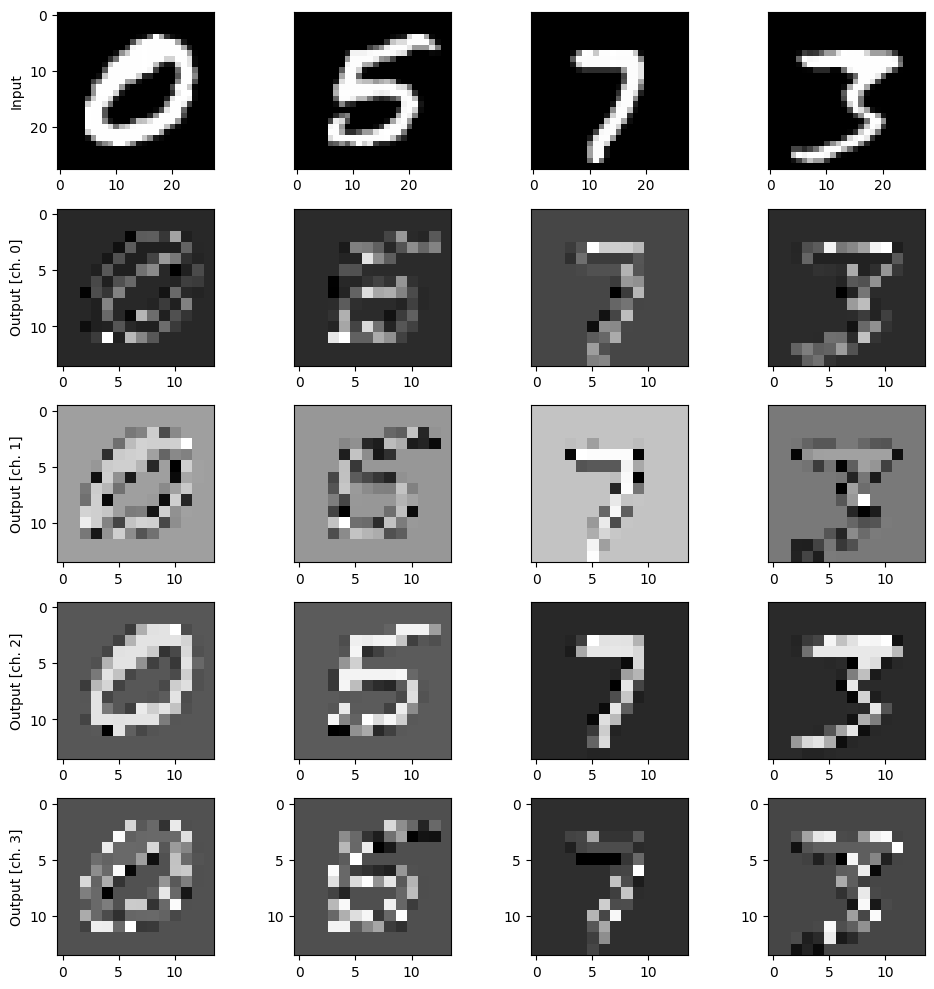

In [32]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


Hybrid Quantum-Classical Model
==============================

After applying the quantum convolution layer, we pass the resulting features to a classical neural network for digit classification. The model consists of a single fully connected layer with 10 output nodes, using a softmax activation function to predict the MNIST digits.

The network is trained using a stochastic gradient descent optimizer and a cross-entropy loss function to minimize classification errors.


### Explanation of `MyModel` Function

The `MyModel` function creates and returns a custom Keras model designed for classification tasks.


**Model Structure**: It uses a sequential model with several layers:
  - `Flatten()`: Converts the input image into a 1D vector.
  - `Dense(128, activation="relu")`: A dense layer with 128 units and ReLU activation, including L2 regularization to prevent overfitting.
  - `Dropout(0.5)`: Applies dropout to randomly ignore 50% of neurons during training to reduce overfitting.
  - `Dense(64, activation="relu")`: Another dense layer with 64 units and ReLU activation, with L2 regularization.
  - `Dropout(0.5)`: Applies dropout again for further regularization.
  - `Dense(10, activation="softmax")`: The output layer with 10 units (one for each class) and softmax activation to produce probability distributions over the classes.

**Compilation**: The model is compiled using the Adam optimizer and sparse categorical crossentropy loss function, with accuracy as the evaluation metric. This setup is suitable for training a neural network on classification tasks with multiple classes.

In [34]:
# Import libraries
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = models.Sequential([
        layers.Flatten(),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


This model is trained by iterating over specified ranges of epoch values and layer counts to train multiple instances of a model with varying configurations. For each configuration, it initializes the model, trains it, and saves the training history along with optionally saving the model weights. This approach allows for systematic experimentation with different model parameters to evaluate their impact on performance.

In [37]:
# Define ranges for epochs and layers
epochs_range = range(10, 51, 10)  # Example: 10, 20, 30, 40, 50
layers_range = range(1, 6)  # Example: 1 to 5 layers

# Initialize dictionary to store training history
history_dict = {}

# Iterate over different numbers of epochs and layers
for n_epochs in epochs_range:
    for n_layers in layers_range:
        # Set random seeds for reproducibility
        np.random.seed(0)
        tf.random.set_seed(0)

        # Initialize model with the current number of layers
        q_model = MyModel()

        # Print statement for current configuration
        print(f"Training with {n_epochs} epochs and {n_layers} layers...")

        # Train the model
        q_history = q_model.fit(
            q_train_images,
            train_labels,
            validation_data=(q_test_images, test_labels),
            batch_size=4,
            epochs=n_epochs,
            verbose=2,
        )

        # Save the training history
        history_dict[(n_epochs, n_layers)] = q_history.history

        # Optionally, save the model weights
        q_model.save(f"model_{n_epochs}epochs_{n_layers}layers.h5")

Training with 10 epochs and 1 layers...
Epoch 1/10
35/35 - 2s - 58ms/step - accuracy: 0.1071 - loss: 4.9335 - val_accuracy: 0.1167 - val_loss: 4.5317
Epoch 2/10
35/35 - 0s - 13ms/step - accuracy: 0.0929 - loss: 4.2741 - val_accuracy: 0.0500 - val_loss: 4.0123
Epoch 3/10
35/35 - 0s - 5ms/step - accuracy: 0.1357 - loss: 3.7895 - val_accuracy: 0.1000 - val_loss: 3.6279
Epoch 4/10
35/35 - 0s - 10ms/step - accuracy: 0.1643 - loss: 3.4364 - val_accuracy: 0.0500 - val_loss: 3.4225
Epoch 5/10
35/35 - 0s - 6ms/step - accuracy: 0.2000 - loss: 3.2298 - val_accuracy: 0.3333 - val_loss: 3.1712
Epoch 6/10
35/35 - 0s - 9ms/step - accuracy: 0.2214 - loss: 3.0098 - val_accuracy: 0.1500 - val_loss: 3.0227
Epoch 7/10
35/35 - 0s - 9ms/step - accuracy: 0.2357 - loss: 2.8675 - val_accuracy: 0.3500 - val_loss: 2.8909
Epoch 8/10
35/35 - 0s - 9ms/step - accuracy: 0.3357 - loss: 2.7379 - val_accuracy: 0.4333 - val_loss: 2.7284
Epoch 9/10
35/35 - 0s - 9ms/step - accuracy: 0.3214 - loss: 2.5603 - val_accuracy: 0.

Training with 10 epochs and 2 layers...
Epoch 1/10
35/35 - 2s - 57ms/step - accuracy: 0.1429 - loss: 4.9277 - val_accuracy: 0.1333 - val_loss: 4.5000
Epoch 2/10
35/35 - 0s - 5ms/step - accuracy: 0.1357 - loss: 4.2182 - val_accuracy: 0.2167 - val_loss: 3.9432
Epoch 3/10
35/35 - 0s - 9ms/step - accuracy: 0.2286 - loss: 3.7126 - val_accuracy: 0.1833 - val_loss: 3.5783
Epoch 4/10
35/35 - 0s - 9ms/step - accuracy: 0.1786 - loss: 3.4260 - val_accuracy: 0.1833 - val_loss: 3.3146
Epoch 5/10
35/35 - 0s - 8ms/step - accuracy: 0.2643 - loss: 3.1337 - val_accuracy: 0.3000 - val_loss: 3.1054
Epoch 6/10
35/35 - 0s - 9ms/step - accuracy: 0.2929 - loss: 2.9791 - val_accuracy: 0.3333 - val_loss: 2.9533
Epoch 7/10
35/35 - 0s - 8ms/step - accuracy: 0.3214 - loss: 2.7416 - val_accuracy: 0.3833 - val_loss: 2.7757
Epoch 8/10
35/35 - 0s - 9ms/step - accuracy: 0.4143 - loss: 2.5580 - val_accuracy: 0.4000 - val_loss: 2.6505
Epoch 9/10
35/35 - 0s - 11ms/step - accuracy: 0.4000 - loss: 2.4009 - val_accuracy: 0.4

Training with 10 epochs and 3 layers...
Epoch 1/10
35/35 - 3s - 79ms/step - accuracy: 0.1071 - loss: 4.9139 - val_accuracy: 0.1167 - val_loss: 4.5052
Epoch 2/10
35/35 - 0s - 6ms/step - accuracy: 0.0714 - loss: 4.2563 - val_accuracy: 0.0500 - val_loss: 3.9671
Epoch 3/10
35/35 - 0s - 9ms/step - accuracy: 0.1714 - loss: 3.7253 - val_accuracy: 0.1667 - val_loss: 3.6331
Epoch 4/10
35/35 - 0s - 9ms/step - accuracy: 0.2071 - loss: 3.4584 - val_accuracy: 0.1833 - val_loss: 3.3773
Epoch 5/10
35/35 - 0s - 9ms/step - accuracy: 0.2429 - loss: 3.1833 - val_accuracy: 0.1667 - val_loss: 3.1356
Epoch 6/10
35/35 - 0s - 8ms/step - accuracy: 0.2357 - loss: 3.0500 - val_accuracy: 0.2167 - val_loss: 3.0048
Epoch 7/10
35/35 - 0s - 5ms/step - accuracy: 0.2929 - loss: 2.8735 - val_accuracy: 0.2167 - val_loss: 2.8690
Epoch 8/10
35/35 - 0s - 9ms/step - accuracy: 0.3000 - loss: 2.6933 - val_accuracy: 0.3500 - val_loss: 2.7440
Epoch 9/10
35/35 - 0s - 7ms/step - accuracy: 0.3643 - loss: 2.4851 - val_accuracy: 0.41

Training with 10 epochs and 4 layers...
Epoch 1/10
35/35 - 2s - 61ms/step - accuracy: 0.1429 - loss: 4.9420 - val_accuracy: 0.1500 - val_loss: 4.4293
Epoch 2/10
35/35 - 0s - 6ms/step - accuracy: 0.1571 - loss: 4.1415 - val_accuracy: 0.1500 - val_loss: 3.9069
Epoch 3/10
35/35 - 0s - 9ms/step - accuracy: 0.1214 - loss: 3.7118 - val_accuracy: 0.2500 - val_loss: 3.5075
Epoch 4/10
35/35 - 0s - 10ms/step - accuracy: 0.2214 - loss: 3.2862 - val_accuracy: 0.2333 - val_loss: 3.2631
Epoch 5/10
35/35 - 0s - 8ms/step - accuracy: 0.1643 - loss: 3.1339 - val_accuracy: 0.2667 - val_loss: 3.0829
Epoch 6/10
35/35 - 0s - 8ms/step - accuracy: 0.2143 - loss: 2.9475 - val_accuracy: 0.2667 - val_loss: 2.9136
Epoch 7/10
35/35 - 0s - 8ms/step - accuracy: 0.3143 - loss: 2.7578 - val_accuracy: 0.3667 - val_loss: 2.7827
Epoch 8/10
35/35 - 0s - 7ms/step - accuracy: 0.3429 - loss: 2.6053 - val_accuracy: 0.3667 - val_loss: 2.6890
Epoch 9/10
35/35 - 0s - 8ms/step - accuracy: 0.3429 - loss: 2.5177 - val_accuracy: 0.3

Training with 10 epochs and 5 layers...
Epoch 1/10
35/35 - 2s - 68ms/step - accuracy: 0.1143 - loss: 4.9820 - val_accuracy: 0.1500 - val_loss: 4.4746
Epoch 2/10
35/35 - 1s - 27ms/step - accuracy: 0.1929 - loss: 4.2191 - val_accuracy: 0.1333 - val_loss: 4.0030
Epoch 3/10
35/35 - 0s - 11ms/step - accuracy: 0.1286 - loss: 3.8098 - val_accuracy: 0.2167 - val_loss: 3.5938
Epoch 4/10
35/35 - 1s - 18ms/step - accuracy: 0.1714 - loss: 3.4587 - val_accuracy: 0.1667 - val_loss: 3.3665
Epoch 5/10
35/35 - 1s - 17ms/step - accuracy: 0.2000 - loss: 3.2162 - val_accuracy: 0.2667 - val_loss: 3.1569
Epoch 6/10
35/35 - 0s - 12ms/step - accuracy: 0.2714 - loss: 3.0000 - val_accuracy: 0.2833 - val_loss: 2.9725
Epoch 7/10
35/35 - 0s - 9ms/step - accuracy: 0.2643 - loss: 2.8811 - val_accuracy: 0.3333 - val_loss: 2.8811
Epoch 8/10
35/35 - 0s - 10ms/step - accuracy: 0.3357 - loss: 2.6697 - val_accuracy: 0.4333 - val_loss: 2.7409
Epoch 9/10
35/35 - 0s - 9ms/step - accuracy: 0.3643 - loss: 2.5745 - val_accuracy

Training with 20 epochs and 1 layers...
Epoch 1/20
35/35 - 2s - 58ms/step - accuracy: 0.0929 - loss: 4.9064 - val_accuracy: 0.1667 - val_loss: 4.4059
Epoch 2/20
35/35 - 0s - 6ms/step - accuracy: 0.1214 - loss: 4.0945 - val_accuracy: 0.1667 - val_loss: 3.8324
Epoch 3/20
35/35 - 0s - 5ms/step - accuracy: 0.1643 - loss: 3.6133 - val_accuracy: 0.1667 - val_loss: 3.4622
Epoch 4/20
35/35 - 0s - 10ms/step - accuracy: 0.1714 - loss: 3.3206 - val_accuracy: 0.2000 - val_loss: 3.2050
Epoch 5/20
35/35 - 0s - 9ms/step - accuracy: 0.1857 - loss: 3.0197 - val_accuracy: 0.1833 - val_loss: 3.0053
Epoch 6/20
35/35 - 0s - 7ms/step - accuracy: 0.1929 - loss: 2.8801 - val_accuracy: 0.1667 - val_loss: 2.8752
Epoch 7/20
35/35 - 0s - 9ms/step - accuracy: 0.2214 - loss: 2.7786 - val_accuracy: 0.2167 - val_loss: 2.7644
Epoch 8/20
35/35 - 0s - 9ms/step - accuracy: 0.2571 - loss: 2.6481 - val_accuracy: 0.3167 - val_loss: 2.6394
Epoch 9/20
35/35 - 0s - 6ms/step - accuracy: 0.2714 - loss: 2.5315 - val_accuracy: 0.3

Training with 20 epochs and 2 layers...
Epoch 1/20
35/35 - 3s - 81ms/step - accuracy: 0.1000 - loss: 4.8963 - val_accuracy: 0.1000 - val_loss: 4.4136
Epoch 2/20
35/35 - 1s - 26ms/step - accuracy: 0.1286 - loss: 4.1368 - val_accuracy: 0.1833 - val_loss: 3.8576
Epoch 3/20
35/35 - 0s - 12ms/step - accuracy: 0.1214 - loss: 3.6565 - val_accuracy: 0.1833 - val_loss: 3.4896
Epoch 4/20
35/35 - 0s - 10ms/step - accuracy: 0.2571 - loss: 3.2541 - val_accuracy: 0.1500 - val_loss: 3.2200
Epoch 5/20
35/35 - 0s - 6ms/step - accuracy: 0.2571 - loss: 3.0307 - val_accuracy: 0.2333 - val_loss: 3.0618
Epoch 6/20
35/35 - 0s - 9ms/step - accuracy: 0.2357 - loss: 2.9422 - val_accuracy: 0.2333 - val_loss: 2.9056
Epoch 7/20
35/35 - 0s - 9ms/step - accuracy: 0.1857 - loss: 2.8396 - val_accuracy: 0.3333 - val_loss: 2.7955
Epoch 8/20
35/35 - 0s - 9ms/step - accuracy: 0.3857 - loss: 2.5751 - val_accuracy: 0.2500 - val_loss: 2.6693
Epoch 9/20
35/35 - 0s - 9ms/step - accuracy: 0.3643 - loss: 2.4883 - val_accuracy: 0

Training with 20 epochs and 3 layers...
Epoch 1/20
35/35 - 3s - 82ms/step - accuracy: 0.1214 - loss: 4.9205 - val_accuracy: 0.1500 - val_loss: 4.4508
Epoch 2/20
35/35 - 0s - 11ms/step - accuracy: 0.1000 - loss: 4.1811 - val_accuracy: 0.2167 - val_loss: 3.8650
Epoch 3/20
35/35 - 0s - 7ms/step - accuracy: 0.1429 - loss: 3.6995 - val_accuracy: 0.2667 - val_loss: 3.5049
Epoch 4/20
35/35 - 0s - 6ms/step - accuracy: 0.1714 - loss: 3.3464 - val_accuracy: 0.1333 - val_loss: 3.2796
Epoch 5/20
35/35 - 0s - 6ms/step - accuracy: 0.2214 - loss: 3.0684 - val_accuracy: 0.2500 - val_loss: 3.0603
Epoch 6/20
35/35 - 0s - 9ms/step - accuracy: 0.2357 - loss: 2.8987 - val_accuracy: 0.3667 - val_loss: 2.9008
Epoch 7/20
35/35 - 0s - 11ms/step - accuracy: 0.2857 - loss: 2.6888 - val_accuracy: 0.3167 - val_loss: 2.7254
Epoch 8/20
35/35 - 1s - 19ms/step - accuracy: 0.3214 - loss: 2.6192 - val_accuracy: 0.3333 - val_loss: 2.6234
Epoch 9/20
35/35 - 0s - 11ms/step - accuracy: 0.3714 - loss: 2.4890 - val_accuracy: 

Training with 20 epochs and 4 layers...
Epoch 1/20
35/35 - 2s - 59ms/step - accuracy: 0.1214 - loss: 4.8906 - val_accuracy: 0.1667 - val_loss: 4.4344
Epoch 2/20
35/35 - 0s - 12ms/step - accuracy: 0.1000 - loss: 4.1952 - val_accuracy: 0.1167 - val_loss: 3.8958
Epoch 3/20
35/35 - 0s - 8ms/step - accuracy: 0.1286 - loss: 3.7044 - val_accuracy: 0.3000 - val_loss: 3.5274
Epoch 4/20
35/35 - 0s - 5ms/step - accuracy: 0.2143 - loss: 3.4041 - val_accuracy: 0.1667 - val_loss: 3.2754
Epoch 5/20
35/35 - 0s - 8ms/step - accuracy: 0.2000 - loss: 3.1354 - val_accuracy: 0.3667 - val_loss: 3.0727
Epoch 6/20
35/35 - 0s - 10ms/step - accuracy: 0.2643 - loss: 2.9279 - val_accuracy: 0.2333 - val_loss: 2.9195
Epoch 7/20
35/35 - 0s - 7ms/step - accuracy: 0.3429 - loss: 2.7667 - val_accuracy: 0.3500 - val_loss: 2.7831
Epoch 8/20
35/35 - 0s - 6ms/step - accuracy: 0.3143 - loss: 2.6673 - val_accuracy: 0.3333 - val_loss: 2.6336
Epoch 9/20
35/35 - 0s - 6ms/step - accuracy: 0.3714 - loss: 2.4455 - val_accuracy: 0.

Training with 20 epochs and 5 layers...
Epoch 1/20
35/35 - 3s - 90ms/step - accuracy: 0.0929 - loss: 4.9323 - val_accuracy: 0.1500 - val_loss: 4.4678
Epoch 2/20
35/35 - 1s - 21ms/step - accuracy: 0.0929 - loss: 4.1765 - val_accuracy: 0.1667 - val_loss: 3.8998
Epoch 3/20
35/35 - 0s - 7ms/step - accuracy: 0.1857 - loss: 3.7132 - val_accuracy: 0.2333 - val_loss: 3.5284
Epoch 4/20
35/35 - 0s - 7ms/step - accuracy: 0.2071 - loss: 3.3629 - val_accuracy: 0.2667 - val_loss: 3.2691
Epoch 5/20
35/35 - 0s - 5ms/step - accuracy: 0.2929 - loss: 3.0467 - val_accuracy: 0.3167 - val_loss: 3.1049
Epoch 6/20
35/35 - 0s - 10ms/step - accuracy: 0.2786 - loss: 2.9122 - val_accuracy: 0.3500 - val_loss: 2.9215
Epoch 7/20
35/35 - 0s - 8ms/step - accuracy: 0.3143 - loss: 2.7237 - val_accuracy: 0.4333 - val_loss: 2.7797
Epoch 8/20
35/35 - 0s - 8ms/step - accuracy: 0.3714 - loss: 2.6352 - val_accuracy: 0.4333 - val_loss: 2.6308
Epoch 9/20
35/35 - 0s - 11ms/step - accuracy: 0.4000 - loss: 2.4135 - val_accuracy: 0

Training with 30 epochs and 1 layers...
Epoch 1/30
35/35 - 2s - 58ms/step - accuracy: 0.0929 - loss: 4.9773 - val_accuracy: 0.2000 - val_loss: 4.5471
Epoch 2/30
35/35 - 0s - 6ms/step - accuracy: 0.1143 - loss: 4.2833 - val_accuracy: 0.2500 - val_loss: 3.9976
Epoch 3/30
35/35 - 0s - 8ms/step - accuracy: 0.1571 - loss: 3.8280 - val_accuracy: 0.2667 - val_loss: 3.6112
Epoch 4/30
35/35 - 0s - 9ms/step - accuracy: 0.2357 - loss: 3.4218 - val_accuracy: 0.2167 - val_loss: 3.3798
Epoch 5/30
35/35 - 0s - 10ms/step - accuracy: 0.2000 - loss: 3.2266 - val_accuracy: 0.3000 - val_loss: 3.1389
Epoch 6/30
35/35 - 0s - 6ms/step - accuracy: 0.3286 - loss: 2.9669 - val_accuracy: 0.3167 - val_loss: 2.9538
Epoch 7/30
35/35 - 0s - 9ms/step - accuracy: 0.3143 - loss: 2.8347 - val_accuracy: 0.3833 - val_loss: 2.8071
Epoch 8/30
35/35 - 0s - 8ms/step - accuracy: 0.2714 - loss: 2.7835 - val_accuracy: 0.4333 - val_loss: 2.7142
Epoch 9/30
35/35 - 0s - 10ms/step - accuracy: 0.3929 - loss: 2.4828 - val_accuracy: 0.

Training with 30 epochs and 2 layers...
Epoch 1/30
35/35 - 2s - 62ms/step - accuracy: 0.1071 - loss: 4.8914 - val_accuracy: 0.1167 - val_loss: 4.5201
Epoch 2/30
35/35 - 0s - 11ms/step - accuracy: 0.1429 - loss: 4.2017 - val_accuracy: 0.1167 - val_loss: 3.9286
Epoch 3/30
35/35 - 0s - 9ms/step - accuracy: 0.1500 - loss: 3.7429 - val_accuracy: 0.1667 - val_loss: 3.5265
Epoch 4/30
35/35 - 0s - 6ms/step - accuracy: 0.1643 - loss: 3.3568 - val_accuracy: 0.2500 - val_loss: 3.2589
Epoch 5/30
35/35 - 0s - 8ms/step - accuracy: 0.2357 - loss: 3.1086 - val_accuracy: 0.1833 - val_loss: 3.0675
Epoch 6/30
35/35 - 0s - 9ms/step - accuracy: 0.2786 - loss: 2.8721 - val_accuracy: 0.2333 - val_loss: 2.9159
Epoch 7/30
35/35 - 0s - 5ms/step - accuracy: 0.3214 - loss: 2.7330 - val_accuracy: 0.2833 - val_loss: 2.7443
Epoch 8/30
35/35 - 0s - 6ms/step - accuracy: 0.2714 - loss: 2.6365 - val_accuracy: 0.4500 - val_loss: 2.6041
Epoch 9/30
35/35 - 0s - 7ms/step - accuracy: 0.3786 - loss: 2.5175 - val_accuracy: 0.4

Training with 30 epochs and 3 layers...
Epoch 1/30
35/35 - 2s - 56ms/step - accuracy: 0.0929 - loss: 4.9113 - val_accuracy: 0.1667 - val_loss: 4.3762
Epoch 2/30
35/35 - 0s - 11ms/step - accuracy: 0.1500 - loss: 4.1649 - val_accuracy: 0.0667 - val_loss: 3.8595
Epoch 3/30
35/35 - 0s - 9ms/step - accuracy: 0.1357 - loss: 3.6507 - val_accuracy: 0.3500 - val_loss: 3.4727
Epoch 4/30
35/35 - 0s - 8ms/step - accuracy: 0.1714 - loss: 3.3494 - val_accuracy: 0.1667 - val_loss: 3.2419
Epoch 5/30
35/35 - 0s - 8ms/step - accuracy: 0.1929 - loss: 3.1227 - val_accuracy: 0.2500 - val_loss: 3.0607
Epoch 6/30
35/35 - 0s - 6ms/step - accuracy: 0.2786 - loss: 2.9484 - val_accuracy: 0.2000 - val_loss: 2.9433
Epoch 7/30
35/35 - 0s - 10ms/step - accuracy: 0.2500 - loss: 2.8212 - val_accuracy: 0.3167 - val_loss: 2.7853
Epoch 8/30
35/35 - 0s - 7ms/step - accuracy: 0.3143 - loss: 2.6029 - val_accuracy: 0.3000 - val_loss: 2.6868
Epoch 9/30
35/35 - 0s - 6ms/step - accuracy: 0.3357 - loss: 2.5073 - val_accuracy: 0.

Training with 30 epochs and 4 layers...
Epoch 1/30
35/35 - 2s - 57ms/step - accuracy: 0.0857 - loss: 4.9420 - val_accuracy: 0.1167 - val_loss: 4.3969
Epoch 2/30
35/35 - 0s - 12ms/step - accuracy: 0.1000 - loss: 4.1475 - val_accuracy: 0.1167 - val_loss: 3.8400
Epoch 3/30
35/35 - 0s - 8ms/step - accuracy: 0.1500 - loss: 3.6548 - val_accuracy: 0.0667 - val_loss: 3.4738
Epoch 4/30
35/35 - 0s - 9ms/step - accuracy: 0.2286 - loss: 3.2692 - val_accuracy: 0.1000 - val_loss: 3.2389
Epoch 5/30
35/35 - 0s - 8ms/step - accuracy: 0.1500 - loss: 3.0992 - val_accuracy: 0.2333 - val_loss: 3.0098
Epoch 6/30
35/35 - 0s - 9ms/step - accuracy: 0.2143 - loss: 2.9133 - val_accuracy: 0.3500 - val_loss: 2.8467
Epoch 7/30
35/35 - 0s - 5ms/step - accuracy: 0.2571 - loss: 2.7530 - val_accuracy: 0.4333 - val_loss: 2.7220
Epoch 8/30
35/35 - 0s - 9ms/step - accuracy: 0.2929 - loss: 2.5918 - val_accuracy: 0.4000 - val_loss: 2.5852
Epoch 9/30
35/35 - 0s - 5ms/step - accuracy: 0.2786 - loss: 2.4912 - val_accuracy: 0.4

Training with 30 epochs and 5 layers...
Epoch 1/30
35/35 - 2s - 56ms/step - accuracy: 0.0786 - loss: 4.9531 - val_accuracy: 0.2000 - val_loss: 4.4407
Epoch 2/30
35/35 - 0s - 11ms/step - accuracy: 0.1143 - loss: 4.1987 - val_accuracy: 0.2167 - val_loss: 3.9108
Epoch 3/30
35/35 - 0s - 9ms/step - accuracy: 0.1786 - loss: 3.6670 - val_accuracy: 0.1167 - val_loss: 3.5450
Epoch 4/30
35/35 - 0s - 10ms/step - accuracy: 0.2071 - loss: 3.3557 - val_accuracy: 0.2833 - val_loss: 3.2789
Epoch 5/30
35/35 - 0s - 8ms/step - accuracy: 0.3071 - loss: 3.0637 - val_accuracy: 0.2500 - val_loss: 3.0655
Epoch 6/30
35/35 - 0s - 5ms/step - accuracy: 0.2857 - loss: 2.9095 - val_accuracy: 0.2833 - val_loss: 2.9284
Epoch 7/30
35/35 - 0s - 9ms/step - accuracy: 0.3071 - loss: 2.6879 - val_accuracy: 0.3833 - val_loss: 2.7401
Epoch 8/30
35/35 - 0s - 10ms/step - accuracy: 0.4143 - loss: 2.5645 - val_accuracy: 0.3667 - val_loss: 2.6273
Epoch 9/30
35/35 - 0s - 6ms/step - accuracy: 0.3786 - loss: 2.4294 - val_accuracy: 0

Training with 40 epochs and 1 layers...
Epoch 1/40
35/35 - 3s - 75ms/step - accuracy: 0.0714 - loss: 4.9753 - val_accuracy: 0.1500 - val_loss: 4.5178
Epoch 2/40
35/35 - 0s - 12ms/step - accuracy: 0.1857 - loss: 4.1758 - val_accuracy: 0.0833 - val_loss: 4.0142
Epoch 3/40
35/35 - 0s - 9ms/step - accuracy: 0.1786 - loss: 3.8247 - val_accuracy: 0.1000 - val_loss: 3.6653
Epoch 4/40
35/35 - 0s - 7ms/step - accuracy: 0.1571 - loss: 3.4638 - val_accuracy: 0.2833 - val_loss: 3.3670
Epoch 5/40
35/35 - 0s - 9ms/step - accuracy: 0.2071 - loss: 3.2815 - val_accuracy: 0.2000 - val_loss: 3.2021
Epoch 6/40
35/35 - 0s - 6ms/step - accuracy: 0.2571 - loss: 3.0444 - val_accuracy: 0.3000 - val_loss: 3.0299
Epoch 7/40
35/35 - 0s - 8ms/step - accuracy: 0.2714 - loss: 2.8922 - val_accuracy: 0.2333 - val_loss: 2.9111
Epoch 8/40
35/35 - 0s - 7ms/step - accuracy: 0.3000 - loss: 2.7865 - val_accuracy: 0.3500 - val_loss: 2.7350
Epoch 9/40
35/35 - 0s - 8ms/step - accuracy: 0.3357 - loss: 2.5972 - val_accuracy: 0.3

Training with 40 epochs and 2 layers...
Epoch 1/40
35/35 - 4s - 103ms/step - accuracy: 0.1000 - loss: 4.9453 - val_accuracy: 0.2167 - val_loss: 4.4297
Epoch 2/40
35/35 - 0s - 6ms/step - accuracy: 0.1786 - loss: 4.1444 - val_accuracy: 0.1167 - val_loss: 3.8615
Epoch 3/40
35/35 - 0s - 9ms/step - accuracy: 0.1214 - loss: 3.6665 - val_accuracy: 0.1333 - val_loss: 3.4852
Epoch 4/40
35/35 - 0s - 10ms/step - accuracy: 0.2143 - loss: 3.3114 - val_accuracy: 0.3000 - val_loss: 3.2204
Epoch 5/40
35/35 - 0s - 7ms/step - accuracy: 0.2143 - loss: 3.0817 - val_accuracy: 0.1833 - val_loss: 3.0227
Epoch 6/40
35/35 - 0s - 8ms/step - accuracy: 0.1571 - loss: 2.9032 - val_accuracy: 0.2833 - val_loss: 2.8785
Epoch 7/40
35/35 - 0s - 7ms/step - accuracy: 0.2429 - loss: 2.7591 - val_accuracy: 0.3333 - val_loss: 2.7542
Epoch 8/40
35/35 - 0s - 9ms/step - accuracy: 0.2857 - loss: 2.5873 - val_accuracy: 0.3500 - val_loss: 2.6273
Epoch 9/40
35/35 - 0s - 6ms/step - accuracy: 0.3000 - loss: 2.4407 - val_accuracy: 0.

Training with 40 epochs and 3 layers...
Epoch 1/40
35/35 - 2s - 60ms/step - accuracy: 0.0714 - loss: 4.9106 - val_accuracy: 0.0500 - val_loss: 4.4608
Epoch 2/40
35/35 - 0s - 12ms/step - accuracy: 0.1000 - loss: 4.1725 - val_accuracy: 0.1667 - val_loss: 3.8641
Epoch 3/40
35/35 - 0s - 8ms/step - accuracy: 0.1857 - loss: 3.6426 - val_accuracy: 0.3167 - val_loss: 3.4907
Epoch 4/40
35/35 - 0s - 7ms/step - accuracy: 0.1857 - loss: 3.3756 - val_accuracy: 0.2167 - val_loss: 3.2451
Epoch 5/40
35/35 - 0s - 6ms/step - accuracy: 0.2000 - loss: 3.0819 - val_accuracy: 0.3167 - val_loss: 3.0768
Epoch 6/40
35/35 - 0s - 10ms/step - accuracy: 0.2929 - loss: 2.8622 - val_accuracy: 0.3333 - val_loss: 2.8693
Epoch 7/40
35/35 - 0s - 7ms/step - accuracy: 0.2643 - loss: 2.7607 - val_accuracy: 0.3833 - val_loss: 2.7121
Epoch 8/40
35/35 - 0s - 6ms/step - accuracy: 0.2714 - loss: 2.5586 - val_accuracy: 0.3667 - val_loss: 2.5996
Epoch 9/40
35/35 - 0s - 9ms/step - accuracy: 0.2714 - loss: 2.5677 - val_accuracy: 0.

Training with 40 epochs and 4 layers...
Epoch 1/40
35/35 - 2s - 58ms/step - accuracy: 0.1143 - loss: 4.9382 - val_accuracy: 0.1167 - val_loss: 4.4582
Epoch 2/40
35/35 - 0s - 11ms/step - accuracy: 0.1143 - loss: 4.2160 - val_accuracy: 0.1833 - val_loss: 3.9260
Epoch 3/40
35/35 - 0s - 8ms/step - accuracy: 0.1357 - loss: 3.7106 - val_accuracy: 0.3000 - val_loss: 3.5865
Epoch 4/40
35/35 - 0s - 10ms/step - accuracy: 0.2000 - loss: 3.3525 - val_accuracy: 0.3000 - val_loss: 3.2652
Epoch 5/40
35/35 - 0s - 5ms/step - accuracy: 0.2143 - loss: 3.1234 - val_accuracy: 0.3333 - val_loss: 3.0438
Epoch 6/40
35/35 - 0s - 10ms/step - accuracy: 0.3357 - loss: 2.8627 - val_accuracy: 0.4167 - val_loss: 2.8486
Epoch 7/40
35/35 - 0s - 7ms/step - accuracy: 0.3214 - loss: 2.7382 - val_accuracy: 0.3500 - val_loss: 2.7123
Epoch 8/40
35/35 - 0s - 6ms/step - accuracy: 0.3714 - loss: 2.6039 - val_accuracy: 0.3833 - val_loss: 2.5881
Epoch 9/40
35/35 - 0s - 9ms/step - accuracy: 0.4143 - loss: 2.4163 - val_accuracy: 0

Training with 40 epochs and 5 layers...
Epoch 1/40
35/35 - 2s - 59ms/step - accuracy: 0.1071 - loss: 4.9167 - val_accuracy: 0.1000 - val_loss: 4.4573
Epoch 2/40
35/35 - 0s - 6ms/step - accuracy: 0.1286 - loss: 4.1693 - val_accuracy: 0.1667 - val_loss: 3.8879
Epoch 3/40
35/35 - 0s - 7ms/step - accuracy: 0.1286 - loss: 3.7263 - val_accuracy: 0.1000 - val_loss: 3.5797
Epoch 4/40
35/35 - 0s - 9ms/step - accuracy: 0.1571 - loss: 3.3721 - val_accuracy: 0.1833 - val_loss: 3.2761
Epoch 5/40
35/35 - 0s - 8ms/step - accuracy: 0.2214 - loss: 3.1182 - val_accuracy: 0.1333 - val_loss: 3.1177
Epoch 6/40
35/35 - 0s - 10ms/step - accuracy: 0.2643 - loss: 2.9711 - val_accuracy: 0.2167 - val_loss: 2.9202
Epoch 7/40
35/35 - 0s - 7ms/step - accuracy: 0.2929 - loss: 2.7904 - val_accuracy: 0.2500 - val_loss: 2.8046
Epoch 8/40
35/35 - 0s - 8ms/step - accuracy: 0.2857 - loss: 2.6306 - val_accuracy: 0.2833 - val_loss: 2.6904
Epoch 9/40
35/35 - 0s - 9ms/step - accuracy: 0.3214 - loss: 2.5312 - val_accuracy: 0.3

Training with 50 epochs and 1 layers...
Epoch 1/50
35/35 - 2s - 59ms/step - accuracy: 0.1357 - loss: 4.9210 - val_accuracy: 0.0500 - val_loss: 4.4920
Epoch 2/50
35/35 - 0s - 11ms/step - accuracy: 0.1286 - loss: 4.2314 - val_accuracy: 0.1167 - val_loss: 3.9362
Epoch 3/50
35/35 - 0s - 10ms/step - accuracy: 0.1929 - loss: 3.7056 - val_accuracy: 0.1667 - val_loss: 3.6340
Epoch 4/50
35/35 - 0s - 8ms/step - accuracy: 0.1929 - loss: 3.4101 - val_accuracy: 0.1500 - val_loss: 3.3162
Epoch 5/50
35/35 - 0s - 7ms/step - accuracy: 0.2500 - loss: 3.1373 - val_accuracy: 0.2500 - val_loss: 3.1317
Epoch 6/50
35/35 - 0s - 14ms/step - accuracy: 0.2429 - loss: 2.9614 - val_accuracy: 0.2500 - val_loss: 2.9802
Epoch 7/50
35/35 - 0s - 10ms/step - accuracy: 0.2571 - loss: 2.7863 - val_accuracy: 0.4000 - val_loss: 2.8504
Epoch 8/50
35/35 - 1s - 18ms/step - accuracy: 0.2929 - loss: 2.7408 - val_accuracy: 0.3667 - val_loss: 2.7511
Epoch 9/50
35/35 - 1s - 18ms/step - accuracy: 0.3857 - loss: 2.5184 - val_accuracy

Training with 50 epochs and 2 layers...
Epoch 1/50
35/35 - 3s - 88ms/step - accuracy: 0.1286 - loss: 4.9385 - val_accuracy: 0.0833 - val_loss: 4.5432
Epoch 2/50
35/35 - 1s - 24ms/step - accuracy: 0.1500 - loss: 4.1058 - val_accuracy: 0.1833 - val_loss: 3.9156
Epoch 3/50
35/35 - 0s - 9ms/step - accuracy: 0.1571 - loss: 3.6489 - val_accuracy: 0.1833 - val_loss: 3.5431
Epoch 4/50
35/35 - 0s - 6ms/step - accuracy: 0.2071 - loss: 3.3215 - val_accuracy: 0.2333 - val_loss: 3.2732
Epoch 5/50
35/35 - 0s - 5ms/step - accuracy: 0.1643 - loss: 3.1380 - val_accuracy: 0.2833 - val_loss: 3.0775
Epoch 6/50
35/35 - 0s - 9ms/step - accuracy: 0.2714 - loss: 2.8879 - val_accuracy: 0.3000 - val_loss: 2.9202
Epoch 7/50
35/35 - 0s - 9ms/step - accuracy: 0.2500 - loss: 2.7537 - val_accuracy: 0.3000 - val_loss: 2.8194
Epoch 8/50
35/35 - 0s - 7ms/step - accuracy: 0.3857 - loss: 2.5671 - val_accuracy: 0.3167 - val_loss: 2.6329
Epoch 9/50
35/35 - 0s - 6ms/step - accuracy: 0.4214 - loss: 2.4378 - val_accuracy: 0.3

Training with 50 epochs and 3 layers...
Epoch 1/50
35/35 - 2s - 57ms/step - accuracy: 0.1143 - loss: 4.9425 - val_accuracy: 0.1333 - val_loss: 4.4217
Epoch 2/50
35/35 - 0s - 12ms/step - accuracy: 0.1286 - loss: 4.1198 - val_accuracy: 0.1833 - val_loss: 3.8354
Epoch 3/50
35/35 - 0s - 9ms/step - accuracy: 0.1429 - loss: 3.6371 - val_accuracy: 0.1833 - val_loss: 3.4531
Epoch 4/50
35/35 - 0s - 9ms/step - accuracy: 0.1357 - loss: 3.2893 - val_accuracy: 0.0667 - val_loss: 3.2212
Epoch 5/50
35/35 - 0s - 7ms/step - accuracy: 0.1929 - loss: 3.0521 - val_accuracy: 0.2667 - val_loss: 3.0173
Epoch 6/50
35/35 - 0s - 9ms/step - accuracy: 0.2500 - loss: 2.9006 - val_accuracy: 0.2833 - val_loss: 2.8853
Epoch 7/50
35/35 - 0s - 9ms/step - accuracy: 0.2786 - loss: 2.7296 - val_accuracy: 0.2833 - val_loss: 2.7822
Epoch 8/50
35/35 - 0s - 9ms/step - accuracy: 0.3929 - loss: 2.5571 - val_accuracy: 0.3833 - val_loss: 2.6397
Epoch 9/50
35/35 - 0s - 7ms/step - accuracy: 0.3643 - loss: 2.4419 - val_accuracy: 0.3

Training with 50 epochs and 4 layers...
Epoch 1/50
35/35 - 2s - 59ms/step - accuracy: 0.1214 - loss: 4.9445 - val_accuracy: 0.1667 - val_loss: 4.4643
Epoch 2/50
35/35 - 0s - 6ms/step - accuracy: 0.1214 - loss: 4.1927 - val_accuracy: 0.1833 - val_loss: 3.9076
Epoch 3/50
35/35 - 0s - 10ms/step - accuracy: 0.2286 - loss: 3.6577 - val_accuracy: 0.1167 - val_loss: 3.5155
Epoch 4/50
35/35 - 0s - 7ms/step - accuracy: 0.1714 - loss: 3.3751 - val_accuracy: 0.1833 - val_loss: 3.2846
Epoch 5/50
35/35 - 0s - 10ms/step - accuracy: 0.2286 - loss: 3.0825 - val_accuracy: 0.2000 - val_loss: 3.0985
Epoch 6/50
35/35 - 0s - 8ms/step - accuracy: 0.2357 - loss: 2.9513 - val_accuracy: 0.2667 - val_loss: 2.9295
Epoch 7/50
35/35 - 0s - 11ms/step - accuracy: 0.3000 - loss: 2.7365 - val_accuracy: 0.3167 - val_loss: 2.7941
Epoch 8/50
35/35 - 0s - 11ms/step - accuracy: 0.2786 - loss: 2.6591 - val_accuracy: 0.3667 - val_loss: 2.6711
Epoch 9/50
35/35 - 1s - 17ms/step - accuracy: 0.4071 - loss: 2.5263 - val_accuracy:

Training with 50 epochs and 5 layers...
Epoch 1/50
35/35 - 3s - 91ms/step - accuracy: 0.1071 - loss: 4.9531 - val_accuracy: 0.1667 - val_loss: 4.5303
Epoch 2/50
35/35 - 0s - 6ms/step - accuracy: 0.2143 - loss: 4.1786 - val_accuracy: 0.2167 - val_loss: 3.9734
Epoch 3/50
35/35 - 0s - 6ms/step - accuracy: 0.1857 - loss: 3.6861 - val_accuracy: 0.0667 - val_loss: 3.5840
Epoch 4/50
35/35 - 0s - 9ms/step - accuracy: 0.1857 - loss: 3.3991 - val_accuracy: 0.1500 - val_loss: 3.3171
Epoch 5/50
35/35 - 0s - 8ms/step - accuracy: 0.2286 - loss: 3.2022 - val_accuracy: 0.1500 - val_loss: 3.1465
Epoch 6/50
35/35 - 0s - 9ms/step - accuracy: 0.2714 - loss: 2.9413 - val_accuracy: 0.2667 - val_loss: 2.9928
Epoch 7/50
35/35 - 0s - 7ms/step - accuracy: 0.3071 - loss: 2.7747 - val_accuracy: 0.2667 - val_loss: 2.8427
Epoch 8/50
35/35 - 0s - 8ms/step - accuracy: 0.3643 - loss: 2.5627 - val_accuracy: 0.3167 - val_loss: 2.7260
Epoch 9/50
35/35 - 0s - 9ms/step - accuracy: 0.3500 - loss: 2.4813 - val_accuracy: 0.38

**CLASSICAL MODEL**

---



In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


**Model Explanation:**

This initializes a classical model with varying numbers of layers and epochs, using a nested loop to iterate through different configurations. For each combination, it trains the model with early stopping and checkpointing callbacks to optimize performance and save the best model. Training history is stored in a dictionary for each configuration, and details of the training process are printed out.

In [41]:
# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'best_classical_model_{n_epochs}epochs_{n_layers}layers.keras', save_best_only=True) # Change the file extension to '.keras'

# Train the classical model
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
35/35 - 2s - 68ms/step - accuracy: 0.1214 - loss: 4.6581 - val_accuracy: 0.3167 - val_loss: 3.9451
Epoch 2/10
35/35 - 1s - 27ms/step - accuracy: 0.2571 - loss: 3.6202 - val_accuracy: 0.3833 - val_loss: 3.3793
Epoch 3/10
35/35 - 0s - 13ms/step - accuracy: 0.3500 - loss: 3.2291 - val_accuracy: 0.5333 - val_loss: 3.0136
Epoch 4/10
35/35 - 1s - 17ms/step - accuracy: 0.4857 - loss: 2.8577 - val_accuracy: 0.6167 - val_loss: 2.6625
Epoch 5/10
35/35 - 1s - 15ms/step - accuracy: 0.5571 - loss: 2.6274 - val_accuracy: 0.6500 - val_loss: 2.4144
Epoch 6/10
35/35 - 1s - 15ms/step - accuracy: 0.5429 - loss: 2.3534 - val_accuracy: 0.6667 - val_loss: 2.1462
Epoch 7/10
35/35 - 0s - 8ms/step - accuracy: 0.6571 - loss: 2.1712 - val_accuracy: 0.6500 - val_loss: 2.0746
Epoch 8/10
35/35 - 0s - 10ms/step - accuracy: 0.7143 - loss: 1.9867 - val_accuracy: 0.6833 - val_loss: 1.8972
Epoch 9/10
35/35 - 0s - 8ms/step - accuracy: 0.8071 - loss: 1.7655 - val_accuracy: 0.7167 - val_loss: 1.7849
Epoch 10/10


In [42]:
# Initialize a dictionary to store history
history_dict = {}

for n_epochs in epochs_range:
    for n_layers in layers_range:
        # Set random seeds for reproducibility
        np.random.seed(0)
        tf.random.set_seed(0)

        # Initialize the classical model with the current number of layers
        c_model = MyModel()

        # Print statement for current configuration
        print(f"Training with {n_epochs} epochs and {n_layers} layers...")

        # Define callbacks for early stopping and model checkpointing
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        # model_checkpoint = ModelCheckpoint(f'best_classical_model_{n_epochs}epochs_{n_layers}layers.h5', save_best_only=True)

        # Train the classical model
        c_history = c_model.fit(
            train_images,
            train_labels,
            validation_data=(test_images, test_labels),
            batch_size=4,
            epochs=n_epochs,
            verbose=2,
            callbacks=[early_stopping, model_checkpoint]
        )

        # Save the training history
        history_dict[(n_epochs, n_layers)] = c_history.history

        # Optionally, print out training history details
        print(f"History for {n_epochs} epochs and {n_layers} layers:")
        print(c_history.history)

Training with 10 epochs and 1 layers...
Epoch 1/10
35/35 - 2s - 62ms/step - accuracy: 0.1143 - loss: 4.6252 - val_accuracy: 0.2833 - val_loss: 3.9362
Epoch 2/10
35/35 - 0s - 9ms/step - accuracy: 0.2500 - loss: 3.6970 - val_accuracy: 0.5000 - val_loss: 3.3886
Epoch 3/10
35/35 - 1s - 20ms/step - accuracy: 0.3143 - loss: 3.2624 - val_accuracy: 0.4833 - val_loss: 3.0683
Epoch 4/10
35/35 - 1s - 19ms/step - accuracy: 0.4143 - loss: 2.8440 - val_accuracy: 0.5333 - val_loss: 2.7376
Epoch 5/10
35/35 - 1s - 17ms/step - accuracy: 0.4714 - loss: 2.6419 - val_accuracy: 0.5833 - val_loss: 2.4971
Epoch 6/10
35/35 - 0s - 12ms/step - accuracy: 0.5929 - loss: 2.4015 - val_accuracy: 0.6333 - val_loss: 2.2544
Epoch 7/10
35/35 - 1s - 17ms/step - accuracy: 0.5857 - loss: 2.2430 - val_accuracy: 0.6833 - val_loss: 2.1048
Epoch 8/10
35/35 - 0s - 13ms/step - accuracy: 0.6714 - loss: 2.0076 - val_accuracy: 0.6667 - val_loss: 1.9996
Epoch 9/10
35/35 - 0s - 10ms/step - accuracy: 0.6500 - loss: 1.9468 - val_accurac

Results
=======

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.

The code sets up a grid of subplots to compare the performance of quantum and classical models across various configurations. For each combination of epochs and layers, it plots the validation accuracy and loss of both models on separate subplots. The plots are organized in a grid format, allowing visual comparison of how different configurations impact model performance.

<ipython-input-43-6e15d02eb4f0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


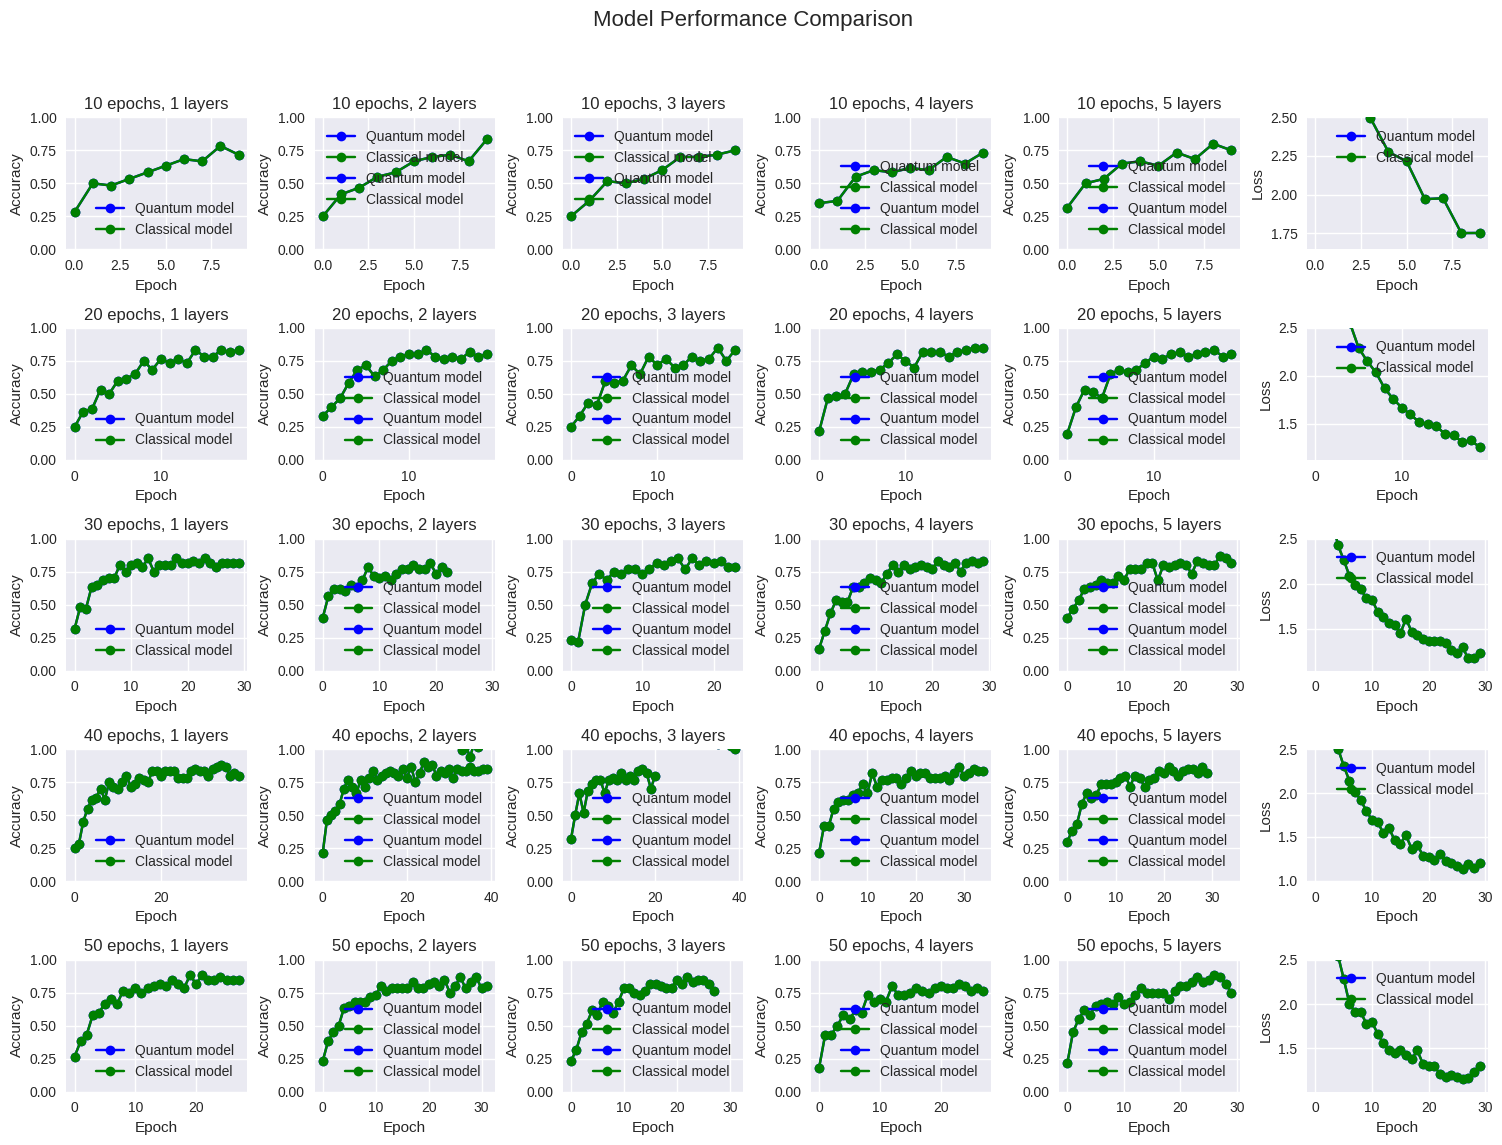

In [43]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Initialize subplots for multiple configurations
fig, axes = plt.subplots(len(epochs_range), len(layers_range) + 1, figsize=(15, 12))
fig.suptitle("Model Performance Comparison", fontsize=16)

for i, n_epochs in enumerate(epochs_range):
    for j, n_layers in enumerate(layers_range):
        # Plot accuracy
        ax = axes[i, j]
        q_key = (n_epochs, n_layers)
        c_key = (n_epochs, n_layers)

        if q_key in history_dict:
            ax.plot(history_dict[q_key]['val_accuracy'], "-ob", label="Quantum model")
        if c_key in history_dict:
            ax.plot(history_dict[c_key]['val_accuracy'], "-og", label="Classical model")

        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])
        ax.set_xlabel("Epoch")
        ax.set_title(f"{n_epochs} epochs, {n_layers} layers")
        ax.legend()

        # Plot loss
        ax = axes[i, j+1]
        if q_key in history_dict:
            ax.plot(history_dict[q_key]['val_loss'], "-ob", label="Quantum model")
        if c_key in history_dict:
            ax.plot(history_dict[c_key]['val_loss'], "-og", label="Classical model")

        ax.set_ylabel("Loss")
        ax.set_ylim(top=2.5)
        ax.set_xlabel("Epoch")
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Comparing Model Evaluation Metrics with Pandas DataFrame**

---

The code print out a table comparing the evaluation metrics using the pandas library to create a DataFrame that compares evaluation metrics of different models. It iterates over configurations of epochs and layers, collecting the final validation accuracy and loss for both quantum and classical models from the `history_dict`. The results are then organized into a DataFrame and printed for easy comparison of model performance.


In [44]:
import pandas as pd

# Initialize an empty list to store results
results = []

# Iterate over different configurations and collect evaluation metrics
for n_epochs in epochs_range:
    for n_layers in layers_range:
        q_key = (n_epochs, n_layers)
        c_key = (n_epochs, n_layers)

        # Collect metrics for quantum model
        q_acc = history_dict[q_key]['val_accuracy'][-1] if q_key in history_dict else None
        q_loss = history_dict[q_key]['val_loss'][-1] if q_key in history_dict else None

        # Collect metrics for classical model
        c_acc = history_dict[c_key]['val_accuracy'][-1] if c_key in history_dict else None
        c_loss = history_dict[c_key]['val_loss'][-1] if c_key in history_dict else None

        # Append metrics to results list
        results.append({
            'Epochs': n_epochs,
            'Layers': n_layers,
            'Quantum Accuracy': q_acc,
            'Quantum Loss': q_loss,
            'Classical Accuracy': c_acc,
            'Classical Loss': c_loss
        })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame
print(df_results)

    Epochs  Layers  Quantum Accuracy  Quantum Loss  Classical Accuracy  \
0       10       1          0.716667      1.752615            0.716667   
1       10       2          0.833333      1.716979            0.833333   
2       10       3          0.750000      1.812360            0.750000   
3       10       4          0.733333      1.701744            0.733333   
4       10       5          0.750000      1.752140            0.750000   
5       20       1          0.833333      1.311343            0.833333   
6       20       2          0.800000      1.383930            0.800000   
7       20       3          0.833333      1.288520            0.833333   
8       20       4          0.850000      1.343830            0.850000   
9       20       5          0.800000      1.253353            0.800000   
10      30       1          0.816667      1.149274            0.816667   
11      30       2          0.750000      1.357481            0.750000   
12      30       3          0.783333  

References
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.
